## Bilby: end to end analyis

This notebook goes through the entire process of simulating data and recovering it in various stages.

### Model

Fundamentally, we have a system evolving according to
$$ \phi(t) = \phi_0 + f \Delta t + \frac{1}{2} \dot{f}\Delta t^2 $$
where
$$ \Delta t = t - t_{\rm ref} $$
while $f$, $\dot{f}$ have physical meanings (i.e. GR terms). Meanwhile, $\phi_0$ is an arbitrary phase offset at the reference time. However, it can have a special meaning, if for example we pin the reference time to an ecclipse (or some other meaningful quantity).

When $\textrm{Mod}(\phi(t)) = \phi_0$, the system has done an integer number of rotations.

### Solving for the obervation time
Let's say we measure the ecclipse time at a number of different points. To calculate the time for the $i^{th}$ rotation, we need to solve

$$ 0 = \frac{1}{2}\dot{f}\Delta t^2 + f \Delta t - i $$

Applying the quadratic formula

$$ \Delta t = -\tau \pm \sqrt{\tau^2 + \frac{2 i}{\dot{f}}} $$

where

$$\tau = \frac{f}{\dot{f}}$$
is the spin-down timescale of the system.

### Simulate some data

Text(0, 0.5, 'Number of rotations')

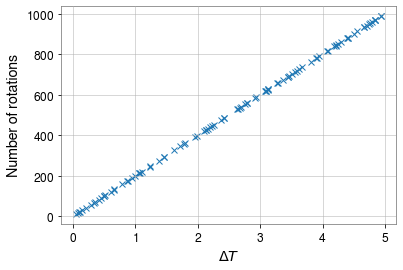

In [2]:
def deltaT_from_quadratic(i, F0, F1):
    tau = F0 / F1
    return - tau + np.sqrt(tau**2 + 2 * i / F1)

F0 = 1 / 0.005  # per-day
F1 = 1e-1 # day's per day

# 100 rotations randomly picked
rotations = np.sort(np.random.randint(0, 1000, 100))
deltaTs = deltaT_from_quadratic(rotations, F0, F1)

plt.plot(deltaTs, rotations, 'x')
plt.xlabel("$\Delta T$")
plt.ylabel("Number of rotations")

## How do we infer the behaviour if we only have the time of the ecclipse?

In the figure above, we *know* apriori the number of rotations. But, for observed data we measuere $\Delta T$ alone. We need a way to see how these measured times are changing with respect to a default model. 

### Naive period-only model
We construct a model for the data:

$$ \phi_m(\Delta T) = \phi_0 + f_0 \Delta T $$

where $\phi_0$ and $f_0$ are unknown variables. Then, we can write down the residual

$$ R_i = \frac{\phi_m(\Delta T_i) - \textrm{Round}(\phi_m(\Delta T_i))}{f_0} $$

In principle, one would need to perform some search over $\phi_0$ and $f_0$ since they are not known. I'll add something about this below, but for now we can just use the "known" values from our simulation and calculate the residual for our simulated data above

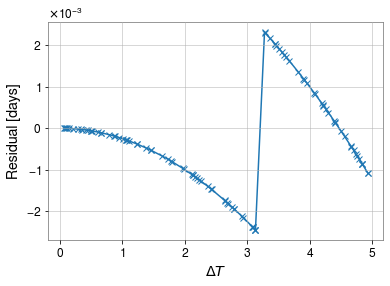

In [3]:
phim = F0 * deltaTs
residual = (phim - np.round(phim)) / F0
plt.plot(deltaTs, residual, '-x')
plt.ylabel("Residual [days]")
plt.xlabel("$\Delta T$")
plt.show()

This shows the intended behaviour when the "fitted" model doesn't include the effect of $\dot{f}$. Notably, because we don't know the number of rotations, we get the "step" jumps when the residual approaches half a rotation.

### Aside
To see a ~10\% change in the residual, we need
$$ \frac{1}{2}\dot{f}\Delta T^2 \sim 0.1 $$
or
$$ \dot{f} \gtrsim 10^{-6} \textrm{day}^{-2}\left(\frac{\textrm{1 year}}{\Delta T}\right)^2 $$

## Search

The residual above was computed using "known" values of $f_0$ and $\phi_0$. For real data, we will be given only
$\{\Delta T_i\}$, a set of measured $\Delta T$ values, and the uncertainty on these, $\sigma_{\Delta T_i}$.

Assuming the uncertainties on $\Delta T$ are Gaussian, we could perform a Bayesian inference with a Gaussian likelihood:

$$ \mathcal{L}(\Delta T_i, \sigma_{\Delta T_i}; \theta) = \mathrm{Normal}(R_i; \sigma) $$

where 

$$ R_i = \frac{\phi_m(\Delta T_i; \theta) - \textrm{Round}(\phi_m(\Delta T_i; \theta))}{f} $$

It is worth saying that $\phi_m$ could be the "naive" model above (in which case $\theta = [\phi_0, f_0]$) or it could be more involved, say adding in $\dot{f}$ (or anything else)).

It is also worth saying that if instead one simply minimizes $\sum (R_i/\sigma)^2$ in a least-squares approach then this is equivalent to a maximisation of the log-likelihood. 

## The effect of uncertainty on the $\Delta T$ measurements

Noise in the $\Delta T$ measurements will obscure the effect. To see a sizeable effect, we need the effect to be large than the typical uncertainties, i.e. 

$$ \frac{1}{2}\dot{f}\Delta T^2\frac{1}{f} \gtrsim \sigma_t $$

or

$$ \frac{\Delta T^2}{\tau} \gtrsim \sigma_t $$

That is, if $\rho = \frac{\Delta T^2}{\tau \sigma_t} \lesssim 1$ then the system is to noisey to see the effect.

To make it clear, here we produce two sets of simulated data: in the first $\rho > 1$ and in the second $\rho < 1$

rho = 500.0


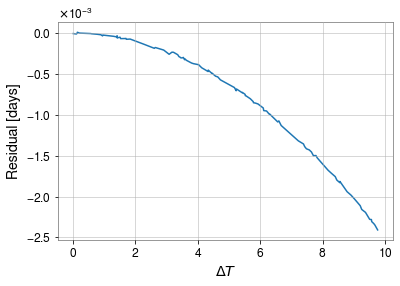

In [4]:
observation_span = 10 # days
F0 = 1 / 0.005  # per-day
F1 = 1e-2 # day's per day
sigmaT = 1e-5
tau = np.abs(F0 / F1)

rho = observation_span**2 / (tau * sigmaT)
print(f"rho = {rho}")

rotations = np.sort(np.random.randint(0, observation_span * F0, 100))
deltaTs = deltaT_from_quadratic(rotations, F0, F1)

phim = F0 * (deltaTs + np.random.normal(0, sigmaT, len(deltaTs)))
residual = (phim - np.round(phim)) / F0
plt.plot(deltaTs, residual)
plt.ylabel("Residual [days]")
plt.xlabel("$\Delta T$")
plt.show()

rho = 5.0


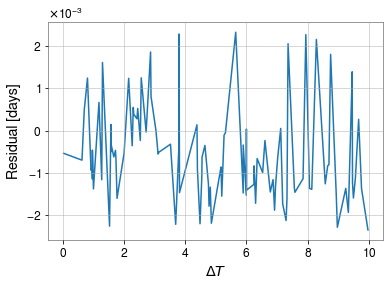

In [13]:
observation_span = 10 # days
F0 = 1 / 0.005  # per-day
F1 = 1e-2 # day's per day
sigmaT = 1e-3
tau = np.abs(F0 / F1)

rho = observation_span ** 2 / (tau * sigmaT)
print(f"rho = {rho}")

rotations = np.sort(np.random.randint(0, observation_span * F0, 100))
deltaTs = deltaT_from_quadratic(rotations, F0, F1)

phim = F0 * (deltaTs + np.random.normal(0, sigmaT, len(deltaTs)))
residual = (phim - np.round(phim)) / F0
plt.plot(deltaTs, residual)
plt.ylabel("Residual [days]")
plt.xlabel("$\Delta T$")
plt.show()

## Values used in the data simulation
Values used [here](https://github.com/mcoughlin/gwemlisa/blob/master/bin/periodPhaseseries.ipynb):

In [15]:
P0 = 0.005 # period (days)
Pdot = 1e-11 # abs rate of change of period (days/days)
deltaT = 300 # 300 days of data was simulated
sigmaT = 1e-5 # This was estimated from some bilby runs

F0 = 1 / P0
F1 = - Pdot / P0 ** 2
tau = np.abs(F0 / F1)

rho = deltaT ** 2 / (tau * sigmaT)
print(rho)

18.0


The noise floor is smaller than the typical $\sigma_t$ measurement. This is why I couldn't pull out the trend.